## SVM

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

# Replace -999999 in var3 column with most common value 2 
df_train = df_train.replace(-999999,2)
df_test = df_test.replace(-999999,2)

In [3]:
from sklearn import preprocessing
X = pd.DataFrame(preprocessing.scale(df_train.iloc[:,1:-1]))
y = df_train.TARGET

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale

# First select features based on chi2 and f_classif
p = 5 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(X))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, y)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(X, y)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(X.columns) if chi2_selected[i]]
#print('Chi2 selected {} features {}.'.format(chi2_selected.sum(),chi2_selected_features))
f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(X.columns) if f_classif_selected[i]]
# print('F_classif selected {} features {}.'.format(f_classif_selected.sum(),f_classif_selected_features))

/home/nguyen/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/nguyen/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 21  22  56  57  58  59  80  84  85 131 132 133 134 155 161 162 179 180
 189 192 220 222 234 238 244 248 261 262 303 307 315 319 327 349] are constant.
  UserWarning)


In [4]:
selected = chi2_selected | f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(X.columns, selected) if s]
print (features)

Chi2 & F_classif selected 23 features
[1, 24, 27, 29, 31, 38, 63, 76, 88, 90, 93, 97, 104, 137, 138, 147, 158, 171, 182, 193, 280, 329, 331]


In [5]:
from sklearn import preprocessing
X_tr = preprocessing.scale(df_train[features].as_matrix())
t_tr = df_train['TARGET'].as_matrix()

print(X_tr.mean(axis=0))
print(X_tr.std(axis=0))
print(np.shape(X_tr))
print(np.shape(t_tr))
print(np.count_nonzero(~np.isnan(X_tr))/np.size(X_tr))

[  1.14515774e-15  -1.20744932e-15  -1.08808946e-15   2.84332980e-15
   5.19655864e-15   1.01503102e-15  -2.44932549e-15   4.60573145e-16
  -6.59401591e-15  -1.44824665e-15  -1.08659400e-15  -6.03185615e-15
   1.01503102e-15  -1.08659400e-15  -7.10444887e-16   3.05393910e-15
  -1.73249485e-15  -3.06680079e-16   4.20494057e-15   0.00000000e+00
   1.21737517e-16   2.80451069e-16   1.31992732e-15]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.]
(76020, 23)
(76020,)
1


In [6]:
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.grid_search import GridSearchCV

param_range = np.logspace(-6, 3, 10)
train_scores, test_scores = validation_curve(SVC(), X_tr, t_tr, param_name="gamma", param_range=param_range, 
                                             cv=6, scoring="accuracy", n_jobs=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


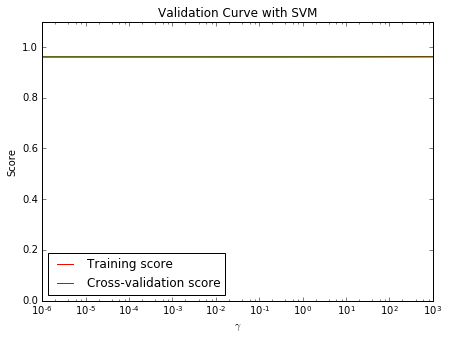

In [7]:
plt.figure(figsize=(7, 5))
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


In [19]:
clf = SVC(gamma=2, C=1,probability=True)
clf.fit(X_tr, t_tr)

# Compute cross-validation score using all CPUs
#from sklearn import svm, cross_validation
#scores = cross_validation.cross_val_score(clf, X_tr, t_tr, n_jobs=3)
#print(scores.mean())

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
X_test = preprocessing.scale(df_test[features].as_matrix())

In [21]:
#t_test=clf.predict(X_test)
t_test=clf.predict_proba(X_test)

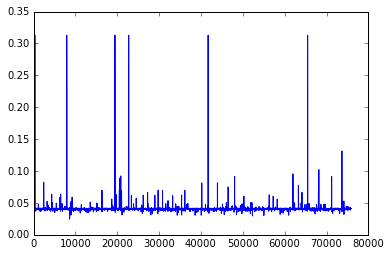

In [27]:
#np.sum(t_test)
plt.plot(t_test[:,1])

In [30]:
id_test = df_test['ID']
submission = pd.DataFrame({"ID":id_test, "TARGET": t_test[:,1]})
submission.to_csv("submission.csv", index=False)